# Mean Square Displacement (MSD)

This is a validation for the E-Cell4 library. Here, we test a mean square displacement (MSD) for each simulation algorithms.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
from ecell4.prelude import *

Making a model for all. A single species `A` is defined. The radius is 5 nm, and the diffusion coefficient is 1um^2/s:

In [2]:
radius, D = 0.005, 1
m = NetworkModel()
m.add_species_attribute(Species("A", radius, D))

Create a random number generator, which is used through whole simulations below:

In [3]:
rng = GSLRandomNumberGenerator()
rng.seed(0)

## Distribution along each axis

First, a distribution along each axis is tested. The distribution after the time `t` should follow the normal distribution with mean 0 and variance `2Dt`.

In [4]:
def plot_displacements(ret):
    distances = []
    for ret_ in ret:
        obs = ret_.observers[1]
        for data in obs.data():
            distances.extend(tuple(data[-1] - data[0]))

    _, bins, _ = plt.hist(distances, bins=30, density=True, facecolor='green', alpha=0.5, label='Simulation')
    xmax = max(abs(bins[0]), abs(bins[-1]))
    x = numpy.linspace(-xmax, +xmax, 101)
    gauss = lambda x, sigmasq: numpy.exp(-0.5 * x * x / sigmasq) / numpy.sqrt(2 * numpy.pi * sigmasq)
    plt.plot(x, gauss(x, 2 * D * duration), 'r-', label='Expected')
    plt.plot(x, gauss(x, sum(numpy.array(distances) ** 2) / len(distances)), 'k--', label='Fitting')
    plt.xlim(x[0], x[-1])
    plt.ylim(0, 1)
    plt.xlabel('Displacement')
    plt.ylabel('Frequenecy')
    plt.legend(loc='best', shadow=True)
    plt.show()

In [5]:
duration = 0.1
N = 50
obs = FixedIntervalTrajectoryObserver(0.01)

Simulating with `egfrd`:

In [6]:
ret1 = ensemble_simulations(
    duration, ndiv=1, model=m, y0={'A': N}, observers=obs,
    solver=('egfrd', Integer3(4, 4, 4)), repeat=50)

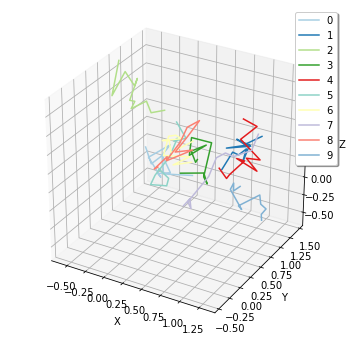

In [7]:
show(ret1[0].observers[1])

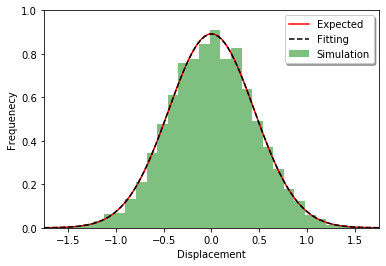

In [8]:
plot_displacements(ret1)

Simulating with `spatiocyte`:

In [9]:
ret2 = ensemble_simulations(
    duration, ndiv=1, model=m, y0={'A': N}, observers=obs,
    solver=('spatiocyte', radius), repeat=50)

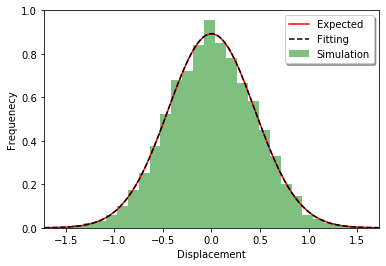

In [10]:
plot_displacements(ret2)

## Mean square displacement

A mean square displacement after the time `t` is euqal to the variance above. The one of a diffusion in volume is `6Dt`. `ecell4.FixedIntervalTrajectoryObserver` enables to track a trajectory of a particle over periodic boundaries.

In [11]:
def test_mean_square_displacement(ret):
    t = numpy.array(ret[0].observers[1].t())
    sd = []
    for ret_ in ret:
        obs = ret_.observers[1]
        for data in obs.data():
            sd.append(numpy.array([length_sq(pos - data[0]) for pos in data]))
    return (t, numpy.average(sd, axis=0), numpy.std(sd, axis=0))

In [12]:
duration = 3.0
N = 50
obs = FixedIntervalTrajectoryObserver(0.01)

Simulating with `egfrd`:

In [13]:
ret1 = ensemble_simulations(
    duration, ndiv=1, model=m, y0={'A': N}, observers=obs,
    solver=('egfrd', Integer3(4, 4, 4)), repeat=10)

In [14]:
t, mean1, std1 = test_mean_square_displacement(ret1)

Simulating with `spatiocyte`:

In [15]:
ret2 = ensemble_simulations(
    duration, ndiv=1, model=m, y0={'A': N}, observers=obs,
    solver=('spatiocyte', radius), repeat=10)

In [16]:
t, mean2, std2 = test_mean_square_displacement(ret2)

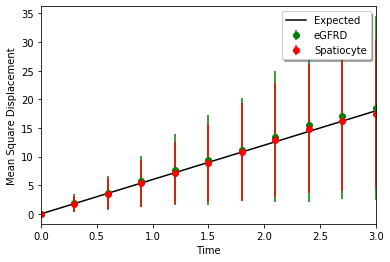

In [17]:
plt.plot(t, 6 * D * t, 'k-', label="Expected")
plt.errorbar(t[::30], mean1[::30], yerr=std1[::30], fmt='go', label="eGFRD")
plt.errorbar(t[::30], mean2[::30], yerr=std2[::30], fmt='ro', label="Spatiocyte")
plt.xlim(t[0], t[-1])
plt.legend(loc="best", shadow=True)
plt.xlabel("Time")
plt.ylabel("Mean Square Displacement")
plt.show()

##  Mean square displacement in a cube

Here, we test a mean square diplacement in a cube. For the periodic boundaries, particles cannot escape from World, and thus the displacement for each axis is less than a half of the World size. In `meso` simulations, unlike `egfrd` and `spatiocyte`, each molecule doesn't have its `ParticleID`. `meso` is just validated in this condition because `FixedIntervalTrajectoryObserver` is only available with `ParticleID`.

In [18]:
def multirun(target, job, repeat, method=None, **kwargs):
    from ecell4.extra.ensemble import run_ensemble, genseeds
    from ecell4.util.session import ResultList
    
    return run_ensemble(target, [list(job) + [genseeds(repeat)]], repeat=repeat, method=method, **kwargs)[0]

In [19]:
def singlerun(job, job_id, task_id):
    from ecell4_base.core import AABB, Real3, GSLRandomNumberGenerator
    from ecell4_base.core import FixedIntervalNumberObserver, FixedIntervalTrajectoryObserver
    from ecell4.util.session import get_factory
    from ecell4.extra.ensemble import getseed

    duration, solver, ndiv, myseeds = job
    rndseed = getseed(myseeds, task_id)

    f = get_factory(*solver)
    f.rng(GSLRandomNumberGenerator(rndseed))
    w = f.world(ones())
    L_11, L_2 = 1.0 / 11, 1.0 / 2
    w.bind_to(m)
    NA = 12
    w.add_molecules(Species("A"), NA, AABB(Real3(5, 5, 5) * L_11, Real3(6, 6, 6) * L_11))

    sim = f.simulator(w)

    retval = [sum(length_sq(p.position() - Real3(L_2, L_2, L_2)) for pid, p in w.list_particles_exact(Species("A"))) / NA]
    for i in range(ndiv):
        sim.run(duration / ndiv)
        mean = sum(length_sq(p.position() - Real3(L_2, L_2, L_2)) for pid, p in w.list_particles_exact(Species("A"))) / NA
        retval.append(mean)
    return numpy.array(retval)

In [20]:
duration = 0.15
ndiv = 20
t = numpy.linspace(0, duration, ndiv + 1)

Simulating with `egfrd`:

In [21]:
ret1 = multirun(singlerun, job=(duration, ("egfrd", Integer3(4, 4, 4)), ndiv), repeat=50)

In [22]:
mean1 = numpy.average(ret1, axis=0)

Simulating with `spatiocyte`:

In [23]:
ret2 = multirun(singlerun, job=(duration, ("spatiocyte", radius), ndiv), repeat=50)

In [24]:
mean2 = numpy.average(ret2, axis=0)

Simulating with `meso`:

In [25]:
ret3 = multirun(singlerun, job=(duration, ("meso", Integer3(11, 11, 11)), ndiv), repeat=50)

In [26]:
mean3 = numpy.average(ret3, axis=0)

Mean square displacement at the uniform distribution in a cube is calculated as follows:

$\int_0^1\int_0^1\int_0^1 dxdydz\ (x-0.5)^2+(y-0.5)^2+(z-0.5)^2=3\left[\frac{(x-0.5)^3}{3}\right]_0^1=0.25$

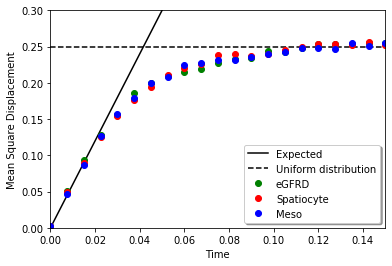

In [27]:
plt.plot(t, 6 * D * t, 'k-', label="Expected")
plt.plot((t[0], t[-1]), (0.25, 0.25), 'k--', label='Uniform distribution')
plt.plot(t, mean1, 'go', label="eGFRD")
plt.plot(t, mean2, 'ro', label="Spatiocyte")
plt.plot(t, mean3, 'bo', label="Meso")
plt.xlim(t[0], t[-1])
plt.ylim(0, 0.3)
plt.legend(loc="best", shadow=True)
plt.xlabel("Time")
plt.ylabel("Mean Square Displacement")
plt.show()

## Mean square displacement in 2D

Spatial simulation with a structure is only supported by `spatiocyte` and `meso` now. Here, mean square displacement on a planar surface is tested for these algorithms.

First, a model is defined with a species `A` which has the same attributes with above except for the location named `M`.

In [28]:
radius, D = 0.005, 1

m = NetworkModel()
A = Species("A", radius, D, "M")
A.set_attribute("dimension", 2)
m.add_species_attribute(A)
M = Species("M", radius, 0)
M.set_attribute("dimension", 2)
m.add_species_attribute(M)

Mean square displacement of a 2D diffusion must follow `4Dt`. The diffusion on a planar surface parallel to yz-plane at the center is tested with `spatiocyte`.

In [29]:
duration = 0.3
N = 50
obs = FixedIntervalTrajectoryObserver(0.01)

Simulating with `spatiocyte`:

In [30]:
ret2 = ensemble_simulations(
    duration, ndiv=1, model=m, y0={'A': N}, observers=obs,
    structures={'M': PlanarSurface(0.5 * ones(), unity(), unitz())},
    solver=('spatiocyte', radius), repeat=50)

In [31]:
t, mean2, std2 = test_mean_square_displacement(ret2)

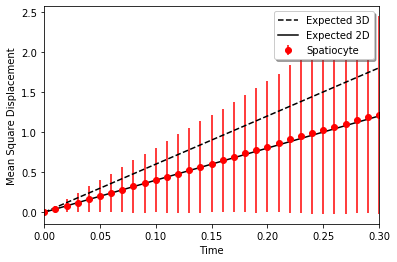

In [32]:
plt.plot(t, 6 * D * t, 'k--', label="Expected 3D")
plt.plot(t, 4 * D * t, 'k-', label="Expected 2D")
plt.errorbar(t, mean2, yerr=std2, fmt='ro', label="Spatiocyte")
plt.xlim(t[0], t[-1])
plt.legend(loc="best", shadow=True)
plt.xlabel("Time")
plt.ylabel("Mean Square Displacement")
plt.show()

Plottig the trajectory of particles on a surface with `spatiocyte`:

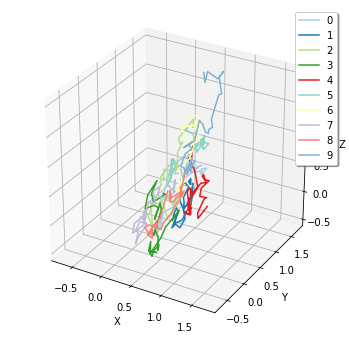

In [33]:
viz.plot_trajectory(ret2[0].observers[1])

Mean square displacement on a planar surface restricted in a cube by periodic boundaries is compared between `meso` and `spatiocyte`.

In [34]:
def singlerun(job, job_id, task_id):
    from ecell4_base.core import AABB, Real3, GSLRandomNumberGenerator
    from ecell4_base.core import FixedIntervalNumberObserver, FixedIntervalTrajectoryObserver
    from ecell4.util.session import get_factory
    from ecell4.extra.ensemble import getseed

    duration, solver, ndiv, myseeds = job
    rndseed = getseed(myseeds, task_id)

    f = get_factory(*solver)
    f.rng(GSLRandomNumberGenerator(rndseed))

    w = f.world(ones())
    L_11, L_2 = 1.0 / 11, 1.0 / 2
    w.bind_to(m)
    NA = 12
    w.add_structure(Species("M"), PlanarSurface(0.5 * ones(), unity(), unitz()))
    w.add_molecules(Species("A"), NA, AABB(ones() * 5 * L_11, ones() * 6 * L_11))

    sim = f.simulator(w)

    retval = [sum(length_sq(p.position() - Real3(L_2, L_2, L_2)) for pid, p in w.list_particles_exact(Species("A"))) / NA]
    for i in range(ndiv):
        sim.run(duration / ndiv)
        mean = sum(length_sq(p.position() - Real3(L_2, L_2, L_2)) for pid, p in w.list_particles_exact(Species("A"))) / NA
        retval.append(mean)
    return numpy.array(retval)

In [35]:
duration = 0.15
ndiv = 20
t = numpy.linspace(0, duration, ndiv + 1)

Simulating with `spatiocyte`:

In [36]:
ret2 = multirun(singlerun, job=(duration, ("spatiocyte", radius), ndiv), repeat=50)

In [37]:
mean2 = numpy.average(ret2, axis=0)

Simulating with `meso`:

In [38]:
ret3 = multirun(singlerun, job=(duration, ("meso", Integer3(11, 11, 11)), ndiv), repeat=50)

In [39]:
mean3 = numpy.average(ret3, axis=0)

Mean square displacement at the uniform distribution on a plane is calculated as follows:

$\int_0^1\int_0^1 dxdydz\ (0.5-0.5)^2+(y-0.5)^2+(z-0.5)^2=2\left[\frac{(x-0.5)^3}{3}\right]_0^1=\frac{1}{6}$

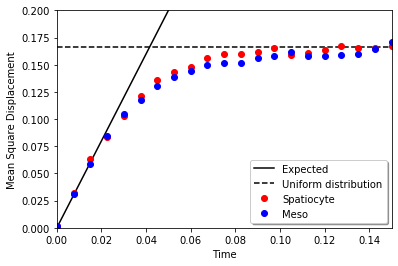

In [40]:
plt.plot(t, 4 * D * t, 'k-', label="Expected")
plt.plot((t[0], t[-1]), (0.5 / 3, 0.5 / 3), 'k--', label='Uniform distribution')
plt.plot(t, mean2, 'ro', label="Spatiocyte")
plt.plot(t, mean3, 'bo', label="Meso")
plt.xlim(t[0], t[-1])
plt.ylim(0, 0.2)
plt.legend(loc="best", shadow=True)
plt.xlabel("Time")
plt.ylabel("Mean Square Displacement")
plt.show()